In [1]:
import pandas as pd
import numpy as np

from typing import List, Tuple, Union, Dict

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import geocoder
import os
import random

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import datetime
from dateutil import tz
import re
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

import warnings
import seaborn as sns
import ephem

import tqdm
from sklearn.neural_network import MLPRegressor

warnings.simplefilter("ignore")


In [2]:
class Config:
    train_path = "../input/train_v2.csv"
    test_path = "../input/test_v2.csv"
    sample_submission_path = "../input/sample_submission.csv"
    output_path = "../submission/"
    seed = 42
    n_splits = 4

In [3]:
random.seed(Config.seed)
os.environ["PYTHONHASHSEED"] = str(Config.seed)
np.random.seed(Config.seed)

In [4]:
def preprocessing(df_train: pd.DataFrame):

    # 雪は花粉０そうなので0
    df_train.loc[df_train["pollen_utsunomiya"] == -9998, "pollen_utsunomiya"] = 0
    df_train.loc[df_train["pollen_chiba"] == -9998, "pollen_chiba"] = 0
    df_train.loc[df_train["pollen_tokyo"] == -9998, "pollen_tokyo"] = 0

    # 欠損補完
    df_train = df_train.replace("欠測", np.nan)
    df_train["precipitation_tokyo"] = df_train["precipitation_tokyo"].astype(float)
    df_train["temperature_chiba"] = df_train["temperature_chiba"].astype(float)
    df_train["temperature_tokyo"] = df_train["temperature_tokyo"].astype(float)

    df_train["winddirection_chiba"] = df_train["winddirection_chiba"].fillna(0)
    df_train["winddirection_chiba"] = df_train["winddirection_chiba"].astype(int)
    df_train["winddirection_tokyo"] = df_train["winddirection_tokyo"].fillna(0)
    df_train["winddirection_tokyo"] = df_train["winddirection_tokyo"].astype(int)

    df_train["windspeed_chiba"] = df_train["windspeed_chiba"].astype(float)
    df_train["windspeed_tokyo"] = df_train["windspeed_tokyo"].astype(float)

    np.random.seed(Config.seed)
    lgb_imp = IterativeImputer(
        estimator=LGBMRegressor(random_state=Config.seed, n_estimators=1000),
        max_iter=10,
        initial_strategy="mean",
        imputation_order="ascending",
        verbose=-1,
        random_state=Config.seed,
    )

    df_train = pd.DataFrame(lgb_imp.fit_transform(df_train), columns=df_train.columns)

    # 型がfloatになってしまっているので、もどす。
    df_train[
        ["winddirection_chiba", "winddirection_tokyo", "winddirection_utsunomiya"]
    ] = (
        df_train[
            ["winddirection_chiba", "winddirection_tokyo", "winddirection_utsunomiya"]
        ]
        .round()
        .astype(int)
    )
    df_train[
        [
            "precipitation_tokyo",
            "temperature_chiba",
            "temperature_tokyo",
            "windspeed_chiba",
            "windspeed_tokyo",
        ]
    ] = df_train[
        [
            "precipitation_tokyo",
            "temperature_chiba",
            "temperature_tokyo",
            "windspeed_chiba",
            "windspeed_tokyo",
        ]
    ].astype(
        float
    )
    df_train["datetime"] = df_train["datetime"].astype(int)

    return df_train

In [5]:
def getNearestValue(list, num):
    """
    https://qiita.com/icchi_h/items/fc0df3abb02b51f81657
    概要: リストからある値に最も近い値を返却する関数
    @param list: データ配列
    @param num: 対象値
    @return 対象値に最も近い値
    """

    # リスト要素と対象値の差分を計算し最小値のインデックスを取得
    idx = np.abs(np.asarray(list) - num).argmin()
    return list[idx]

In [6]:
def train_lightgbm_with_cv_log(
    _df: pd.DataFrame,  # 学習データ
    df_test: pd.DataFrame,  # テストデータ
    target_label: str,  # target label
    label_cols: List[str] = [
        "pollen_utsunomiya",
        "pollen_chiba",
        "pollen_tokyo",
    ],
    unused_label: List[str] = [
        "datetime",
        "datetime_dt",
        "year",
    ],
    val_test_split: float = 0.8,
    q: int = -1,
    plot: bool = True,
) -> Union[np.array, List[np.float], pd.DataFrame, np.array]:

    # print(f"========={target_label}==========")

    _df = _df.copy()
    df_test = df_test.copy()
    label = target_label
    cols = [col for col in _df.columns if col not in label_cols + unused_label]

    folds = KFold(n_splits=Config.n_splits, random_state=Config.seed, shuffle=False)
    # folds = TimeSeriesSplit(n_splits=Config.n_splits)
    scores = []
    prediction = np.zeros(len(df_test))
    imps_list = []
    v_test_scores = []

    _val_scores = np.zeros(len(_df))
    pollen_list = list(set(_df[label].tolist()))

    for fold, (train_idx, val_idx) in enumerate(folds.split(_df)):
        print(train_idx)
        np.random.seed(Config.seed)

        df_train = _df.iloc[train_idx].reset_index(drop=True)
        df_val = _df.iloc[val_idx].reset_index(drop=True)

        df_v_val = df_val.iloc[: int(len(df_val) * val_test_split)].reset_index(
            drop=True
        )
        df_v_test = df_val.iloc[int(len(df_val) * val_test_split) :].reset_index(
            drop=True
        )

        if q > 0:
            df_train = df_train[df_train[label] <= q].reset_index(drop=True)
            df_v_val = df_v_val[df_v_val[label] <= q].reset_index(drop=True)

        # model = LGBMRegressor(random_state=Config.seed, n_estimators=1000)
        # model = CatBoostRegressor(random_seed=Config.seed, eval_metric="FairLoss")
        # train_pool = Pool(df_train[cols], np.log1p(df_train[label]))
        # val_pool = Pool(df_v_val[cols], np.log1p(df_v_val[label]))
        

        normalizer = Normalizer().fit(df_train[cols])
        
        model = MLPRegressor(
            hidden_layer_sizes=(300, 200),
            random_state=Config.seed,
            activation="relu",
            solver="adam",
            learning_rate="adaptive",
        )



        model.fit(
            normalizer.transform(df_train[cols]), np.log1p(df_train[label])
        )

        # model.fit(
        #     df_train[cols],
        #     np.log1p(df_train[label]),
        #     #np.log1p(df_train[label] / 4),
        #     #eval_set=(df_val[cols], np.log1p(df_val[label])),
        #     #eval_set=(df_val[cols], np.log1p(df_val[label] / 4)),
        #     eval_set=(df_v_val[cols], np.log1p(df_v_val[label])),
        #     eval_metric="fair",
        #     callbacks=[
        #         lgb.early_stopping(
        #             stopping_rounds=1000, verbose=False
        #         ),  # early_stopping用コールバック関数
        #         lgb.log_evaluation(0),
        #     ],  # コマンドライン出力用コールバック関数
        # )

        # validation
        val_pred = model.predict(normalizer.transform(df_val[cols]))
        # val_pred = np.expm1(val_pred).round() * 4
        # val_pred = np.expm1(val_pred).round()
        val_pred = np.expm1(val_pred)
        val_pred = np.array([getNearestValue(pollen_list, v) for v in val_pred])

        val_score = mean_absolute_error(df_val[label], val_pred)
        scores.append(val_score)

        _val_scores[val_idx] = val_pred

        # test data (not used in train)
        v_test_pred = model.predict(normalizer.transform(df_v_test[cols]))
        # v_test_pred = np.expm1(v_test_pred).round() * 4
        # v_test_pred = np.expm1(v_test_pred).round()
        v_test_pred = np.expm1(v_test_pred)
        v_test_pred = np.array([getNearestValue(pollen_list, v) for v in v_test_pred])
        v_test_score = mean_absolute_error(df_v_test[label], v_test_pred)
        v_test_scores.append(v_test_score)

        _pred = model.predict(normalizer.transform(df_test[cols]))
        # _pred = np.expm1(_pred).round() * 4
        _pred = np.expm1(_pred)
        prediction += _pred / Config.n_splits
        # prediction = prediction.round()

        # imps = model.get_feature_importance(train_pool)
        # imps_list.append(imps)

        if plot:
            _df_v_test = df_v_test.copy()
            _df_v_test["pred"] = v_test_pred
            plt.figure(figsize=(20, 6))
            ax = sns.lineplot(data=_df_v_test, x="datetime_dt", y="pred", label="pred")
            ax = sns.lineplot(data=_df_v_test, x="datetime_dt", y=label, label=label)

    prediction = np.where(prediction < 0, 0, prediction)
    prediction = np.array([getNearestValue(pollen_list, v) for v in prediction])

    #imps = np.mean(imps_list, axis=0)
    #df_imps = pd.DataFrame({"columns": _df[cols].columns.tolist(), "feat_imp": imps})
    #df_imps = df_imps.sort_values("feat_imp", ascending=False).reset_index(drop=True)

    return prediction, scores, _val_scores, v_test_scores


In [7]:
# 時間
def to_datetime(time: datetime.datetime) -> datetime.datetime:
    time = str(time)
    try:
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
    except ValueError:
        time = re.sub("24$", "23", time)
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
        time += datetime.timedelta(hours=1)
    return time


def time_feat(df: pd.DataFrame) -> pd.DataFrame:
    df["datetime_dt"] = df["datetime"].apply(to_datetime)
    df["year"] = df["datetime_dt"].dt.year
    df["month"] = df["datetime_dt"].dt.month
    df["day"] = df["datetime_dt"].dt.day
    df["hour"] = df["datetime_dt"].dt.hour
    df["hour_sin"] = np.sin(df["datetime_dt"].dt.hour * (2 * np.pi / (24 + 1)))
    df["hour_cos"] = np.cos(df["datetime_dt"].dt.hour * (2 * np.pi / (24 + 1)))
    df["weekday"] = df["datetime_dt"].dt.weekday
    df["day_of_year"] = df["datetime_dt"].dt.dayofyear

    return df

In [8]:
def add_precipitation_zero_count_feat(df: pd.DataFrame) -> pd.DataFrame:
    # https://comp.probspace.com/competitions/pollen_counts/discussions/saru_da_mon-Post5943fd8142f960c070d7

    th = 0.5
    for pref in ["utsunomiya", "chiba", "tokyo"]:
        count_list_all = []
        for year in [2017, 2018, 2019, 2020]:
            _df = df[df.year == year].reset_index(drop=True)
            count_list_by_year = []
            n_count = 0
            for e in _df[f"precipitation_{pref}"]:
                if e < th:
                    n_count += 1
                else:
                    n_count = 0
                count_list_by_year.append(np.log1p(n_count))
            count_list_all.extend(count_list_by_year)
        df[f"precipitation_{pref}_count_{th}_2"] = count_list_all

    return df

In [9]:
def remove_noise(
    df: pd.DataFrame,
    window_length: int,
    polyorder: int = 2,
    overwite: bool = False,
    cols=[],
) -> pd.DataFrame:
    _df = df.copy()
    for col in cols:
        np.random.seed(Config.seed)
        # _df[f"{col}_smooth_{window_length}"] = savgol_filter(_df[col])
        if overwite:
            _df[col] = savgol_filter(
                _df[col], window_length=window_length, polyorder=polyorder
            )
        else:
            _df[f"{col}_smooth_{window_length}"] = savgol_filter(
                _df[col], window_length=window_length, polyorder=polyorder
            )
            _df.loc[
                _df[f"{col}_smooth_{window_length}"] < 0,
                f"{col}_smooth_{window_length}",
            ] = 0

    return _df

In [10]:
# ラグ特徴/ローリング特徴量
def add_lag_feat(df: pd.DataFrame, feat: List[str], group: str) -> pd.DataFrame:
    outputs = [df]

    grp_df = df.groupby(group)  # year ごとにシフトする。 各年1~6月期間しかないのでこのようにする。

    for lag in [1, 2, 3, 4, 5]:
        # for lag in list(range(1, 25)):
        # shift
        outputs.append(grp_df[feat].shift(lag).add_prefix(f"shift_{lag}_"))
        # diff
        outputs.append(grp_df[feat].diff(lag).add_prefix(f"diff_{lag}_"))

    # rolling
    windows = [3] + [i * 24 for i in range(1, 3)]
    # windows = [3] + [i * 24 for i in range(1, 10)]
    for window in windows:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f"rolling_{window}_mean_")
        outputs.append(tmp_df.reset_index(drop=True))

    _df = pd.concat(outputs, axis=1)
    return _df

In [11]:
# ラグ特徴/ローリング特徴量
def add_lag_feat_presudo(df: pd.DataFrame, feat: List[str], group: str) -> pd.DataFrame:
    outputs = [df]

    grp_df = df.groupby(group)  # year ごとにシフトする。 各年1~6月期間しかないのでこのようにする。

    #for lag in [1, 2, 3, 4, 5]:
    # for lag in list(range(1, 25)):
    #     # shift
    #     outputs.append(grp_df[feat].shift(lag).add_prefix(f"shift_{lag}_"))
    #     # diff
    #     outputs.append(grp_df[feat].diff(lag).add_prefix(f"diff_{lag}_"))

    # rolling
    windows = [i * 24 for i in range(1, 3)]
    #windows = [3] + [i * 24 for i in range(1, 10)]
    for window in windows:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f"rolling_{window}_mean_")
        outputs.append(tmp_df.reset_index(drop=True).copy())
        
        # tmp_df = grp_df[feat].rolling(window, min_periods=1)
        # tmp_df = tmp_df.max().add_prefix(f"rolling_{window}_max_")        
        # outputs.append(tmp_df.reset_index(drop=True).copy())
        
        # tmp_df = grp_df[feat].rolling(window, min_periods=1)
        # tmp_df = tmp_df.min().add_prefix(f"rolling_{window}_min_")
        # outputs.append(tmp_df.reset_index(drop=True).copy())

    _df = pd.concat(outputs, axis=1)
    return _df

In [12]:
def temperature_decompose(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    from statsmodels.tsa.seasonal import STL

    _df = df.copy()
    np.random.seed(Config.seed)
    # for col in ["temperature_tokyo", "temperature_utsunomiya", "temperature_chiba"]:
    for col in cols:
        np.random.seed(Config.seed)
        res = STL(_df[col], period=24).fit()
        _df[f"{col}_decompose_trend"] = res.trend
        _df[f"{col}_decompose_seasonal"] = res.seasonal
        _df[f"{col}_decompose_resid"] = res.resid
        _df[f"{col}_decompose_minus_trend"] = _df[col] - _df[f"{col}_decompose_trend"]

    return _df

In [13]:
def add_sekisan_ondo2(
    df: pd.DataFrame,
    cols: List[str] = [
        "temperature_utsunomiya",
        "temperature_tokyo",
        "temperature_chiba",
    ],
) -> pd.DataFrame:
    # https://hp.otenki.com/401/
    # 1/1からの毎日の温度の平均を和を算出していく

    dfs = []
    for year in [2017, 2018, 2019, 2020]:
        _df = df[df.year == year].reset_index(drop=True).copy()
        # _df["ymd"] = _df["datetime_dt"].apply(lambda x: x.strftime("%Y%m%d"))

        for col in cols:
            _df.loc[_df[col] < 0, col] = 0
            s = _df[col].sum()
            _df[f"sekisan_ondo_{col}_2"] = _df[col].cumsum()
            # _df[f"sekisan_ondo_{col}_2_ratio"] = _df[f"sekisan_ondo_{col}_2"] / s
        dfs.append(_df)

    _df = pd.concat(dfs)

    return _df

In [14]:
def add_wind_direction_to_cos_sin(
    df: pd.DataFrame,
    cols: List[str] = [
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ],
) -> pd.DataFrame:
    """
    {col} が 0：静穏 の場合 {col}_cos, {col}_sinには、欠損になる
    1：北北東
    2：北東
    3：東北東
    4：東
    5：東南東
    6：南東
    7：南南東
    8：南
    9：南南西
    10：南西
    11：西南西
    12：西
    13：西北西
    14：北西
    15：北北西
    16：北

    """
    df_origin = df.copy()

    direction_map = {
        1: 13,
        2: 14,
        3: 15,
        4: 0,
        5: 1,
        6: 2,
        7: 3,
        8: 4,
        9: 5,
        10: 6,
        11: 7,
        12: 8,
        13: 9,
        14: 10,
        15: 11,
        16: 12,
    }

    pref_list = ["utsunomiya", "tokyo", "chiba"]

    for col in cols:

        _df = df_origin[[col]].copy()
        _df = _df.reset_index()
        _df = _df[_df[col] != 0].reset_index(drop=True)  # 0：静穏 は風の方向ではないので消す
        # _df[col] = _df[col] - 1  # 1 ~ 16 なので 0 ~ 15に変換
        _df[col] = _df[col].apply(lambda x: direction_map[x])

        _df[f"{col}_cos"] = np.cos(2 * np.pi * _df[col] / (_df[col].max() + 1))
        _df[f"{col}_sin"] = np.sin(2 * np.pi * _df[col] / (_df[col].max() + 1))
        _df = _df.drop(col, axis=1)

        df_origin = df_origin.reset_index()
        df_origin = df_origin.merge(_df, on="index", how="left")
        df_origin = df_origin.drop("index", axis=1)
        df_origin[f"{col}_cos"] = df_origin[f"{col}_cos"].fillna(0)
        df_origin[f"{col}_sin"] = df_origin[f"{col}_sin"].fillna(0)

        pref = col.split("_")[-1]
        df_origin[f"{col}_cos_mult_window_speed"] = (
            df_origin[f"windspeed_{pref}"] * df_origin[f"{col}_cos"]
        )  # .fillna(0)
        df_origin[f"{col}_sin_mult_window_speed"] = (
            df_origin[f"windspeed_{pref}"] * df_origin[f"{col}_sin"]
        )

    return df_origin

In [15]:
def add_wind_direction_one_hot(
    df: pd.DataFrame,
    cols=[
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ],
) -> pd.DataFrame:

    num_wind_direction = 17

    dfs = []
    for col in cols:
        data = {f"{col}_one_hot_{i}": [] for i in range(num_wind_direction)}
        for x in df[col].astype(int):
            for i in range(num_wind_direction):
                if x == i:
                    data[f"{col}_one_hot_{i}"].append(1)
                else:
                    data[f"{col}_one_hot_{i}"].append(0)

        _df = pd.DataFrame(data)
        dfs.append(_df)

    return pd.concat([df] + dfs, axis=1)

In [16]:
def get_latlng():

    loc_list = ["宇都宮市中央生涯学習センター", "千葉県環境研究センター", "東京都多摩小平保健所"]
    key_list = ["utsunomiya", "chiba", "tokyo"]

    LATLNG_DICT = {}

    try:

        for i, key in zip(loc_list, key_list):
            loc = geocoder.osm(i, timeout=5.0)            
            LATLNG_DICT[key] = tuple(loc.latlng)
        
    except Exception as e:
        print(e)
        print("APIでのデータ取得に失敗したため、成功時に取得したデータを使います。")
        LATLNG_DICT = {
            "utsunomiya": (36.5594462, 139.88265145),
            "chiba": (35.633642, 140.077749),
            "tokyo": (35.7298652, 139.51664115548698),
        }    

    return LATLNG_DICT

In [17]:
def add_rising_setting(df: pd.DataFrame) -> pd.DataFrame:
    _df = df.copy()

    latlng_dict = get_latlng()
    sun = ephem.Sun()

    ut = ephem.Observer()
    ut.lat = latlng_dict["utsunomiya"][0]
    ut.lon = latlng_dict["utsunomiya"][1]

    tk = ephem.Observer()
    tk.lat = latlng_dict["tokyo"][0]
    tk.lon = latlng_dict["tokyo"][1]

    cb = ephem.Observer()
    cb.lat = latlng_dict["chiba"][0]
    cb.lon = latlng_dict["chiba"][1]

    def get_rising_time(
        observer: ephem.Observer, sun: ephem.Sun, datetime: datetime.datetime
    ):
        observer.date = datetime
        return ephem.localtime(observer.next_rising(sun))

    def get_setting_time(
        observer: ephem.Observer, sun: ephem.Sun, datetime: datetime.datetime
    ):
        observer.date = datetime
        return ephem.localtime(observer.next_setting(sun))

    _df["ymd"] = _df["datetime_dt"].dt.strftime("%Y%m%d")
    dfs = []
    JST = tz.gettz("Asia/Tokyo")
    UTC = tz.gettz("UTC")

    for i, __df in tqdm.tqdm(
        _df[["ymd", "datetime_dt", "hour_sin", "hour_cos"]].groupby("ymd")
    ):
        # datetime_min = __df["datetime_dt"].median().values.tz_localize("Asia/Tokyo")
        datetime_min = __df["datetime_dt"].min().to_pydatetime()
        # print(datetime_min, type(datetime_min))
        datetime_min = (
            datetime_min.replace(tzinfo=JST).astimezone(UTC).replace(tzinfo=None)
        )
        # print(datetime_min)
        datetime_rising_ut = (
            get_rising_time(ut, sun, datetime_min).astimezone(JST).replace(tzinfo=None)
        )
        datetime_setting_ut = (
            get_setting_time(ut, sun, datetime_min).astimezone(JST).replace(tzinfo=None)
        )

        datetime_rising_tk = (
            get_rising_time(tk, sun, datetime_min).astimezone(JST).replace(tzinfo=None)
        )
        datetime_setting_tk = (
            get_setting_time(tk, sun, datetime_min).astimezone(JST).replace(tzinfo=None)
        )

        datetime_rising_cb = (
            get_rising_time(cb, sun, datetime_min).astimezone(JST).replace(tzinfo=None)
        )
        datetime_setting_cb = (
            get_setting_time(cb, sun, datetime_min).astimezone(JST).replace(tzinfo=None)
        )

        __df["sun_rising_rate_ut"] = (__df["datetime_dt"] - datetime_rising_ut).apply(
            lambda x: x.total_seconds() / 60
        ) / ((datetime_setting_ut - datetime_rising_ut).total_seconds() / 60)

        __df.loc[__df["sun_rising_rate_ut"] < 0, "sun_rising_rate_ut"] = 0
        __df.loc[__df["sun_rising_rate_ut"] >= 1, "sun_rising_rate_ut"] = 0

        __df["sun_rising_rate_tk"] = (__df["datetime_dt"] - datetime_rising_tk).apply(
            lambda x: x.total_seconds() / 60
        ) / ((datetime_setting_tk - datetime_rising_tk).total_seconds() / 60)

        __df.loc[__df["sun_rising_rate_tk"] < 0, "sun_rising_rate_tk"] = 0
        __df.loc[__df["sun_rising_rate_tk"] >= 1, "sun_rising_rate_tk"] = 0

        __df["sun_rising_rate_cb"] = (__df["datetime_dt"] - datetime_rising_cb).apply(
            lambda x: x.total_seconds() / 60
        ) / ((datetime_setting_cb - datetime_rising_cb).total_seconds() / 60)

        __df.loc[__df["sun_rising_rate_cb"] < 0, "sun_rising_rate_cb"] = 0
        __df.loc[__df["sun_rising_rate_cb"] >= 1, "sun_rising_rate_cb"] = 0

        __df["diff_rising_tk"] = (__df["datetime_dt"] - datetime_rising_tk).apply(
            lambda x: x.total_seconds() / 60
        )
        __df["diff_setting_tk"] = (datetime_setting_tk - __df["datetime_dt"]).apply(
            lambda x: x.total_seconds() / 60
        )

        # __df["rising_tk"] = ((datetime_setting_tk - datetime_rising_tk).total_seconds() / 60)

        __df["diff_rising_tk"] = (__df["datetime_dt"] - datetime_rising_tk).apply(
            lambda x: x.total_seconds() / 60
        )
        __df["diff_setting_tk"] = (datetime_setting_tk - __df["datetime_dt"]).apply(
            lambda x: x.total_seconds() / 60
        )

        __df["diff_rising_cb"] = (__df["datetime_dt"] - datetime_rising_cb).apply(
            lambda x: x.total_seconds() / 60
        )
        __df["diff_setting_cb"] = (datetime_setting_cb - __df["datetime_dt"]).apply(
            lambda x: x.total_seconds() / 60
        )

        __df["hour_sin_mult_sun_rate_tk"] = (
            __df["sun_rising_rate_tk"] * __df["hour_sin"]
        )
        __df["hour_sin_mult_sun_rate_cb"] = (
            __df["sun_rising_rate_cb"] * __df["hour_sin"]
        )
        __df["hour_sin_mult_sun_rate_ut"] = (
            __df["sun_rising_rate_ut"] * __df["hour_sin"]
        )

        __df["hour_cos_mult_sun_rate_tk"] = (
            __df["sun_rising_rate_tk"] * __df["hour_cos"]
        )
        __df["hour_cos_mult_sun_rate_cb"] = (
            __df["sun_rising_rate_cb"] * __df["hour_cos"]
        )
        __df["hour_cos_mult_sun_rate_ut"] = (
            __df["sun_rising_rate_ut"] * __df["hour_cos"]
        )

        dfs.append(__df)

    df_rising_setting = pd.concat(dfs)
    # print(df_rising_setting.columns.tolist())

    # _df = _df.merge(df_rising_setting, on="datetime_dt", how="left")
    _df = pd.concat(
        [
            _df.drop("ymd", axis=1),
            df_rising_setting.drop(
                ["ymd", "datetime_dt", "hour_sin", "hour_cos"], axis=1
            ),
        ],
        axis=1,
    )

    return _df


In [18]:
# _df = time_feat(df_train)
# _df = add_rising_setting(_df)

In [19]:
#_df[["datetime_dt", "sun_rising_rate_cb"]].head(30)
#_df[["datetime_dt", "sun_rising_rate_ut", "sun_rising_rate_cb", "sun_rising_rate_tk"]].head(30)
#_df[["datetime_dt", "rising_ut", "diff_setting_ut", "rising_cb", "diff_setting_cb", "rising_tk", "diff_setting_tk"]].head(30)

## utsunomiya feat

In [20]:
def make_feature_ut(df: pd.DataFrame) -> pd.DataFrame:
    _df = df.copy()
    _df = time_feat(_df)

    # 降水量カウント
    _df = add_precipitation_zero_count_feat(_df)
    # _df = remove_noise(
    #     _df,
    #     window_length=7,
    #     overwite=False,
    #     cols=[
    #         "precipitation_utsunomiya",
    #         "temperature_utsunomiya",
    #         "windspeed_utsunomiya",
    #     ],
    # )

    _df = add_lag_feat(
        _df,
        ["precipitation_utsunomiya", "temperature_utsunomiya"],
        "year",
    )

    _df = temperature_decompose(_df, ["temperature_utsunomiya"])

    # _df = add_wind_direction_to_cos_sin(
    #     _df,
    #     [
    #         # "winddirection_utsunomiya",
    #         # "winddirection_tokyo",
    #         # "winddirection_chiba"
    #     ],
    # )

    # _df = add_wind_direction_one_hot(_df, ["winddirection_utsunomiya"])

    # _df = add_sekisan_ondo2(_df, cols=["temperature_utsunomiya"])

    _df = add_rising_setting(_df)

    _df = _df.drop(
        [
            "winddirection_utsunomiya",
            "winddirection_tokyo",
            "winddirection_chiba",
            "temperature_tokyo",
            # "windspeed_tokyo",
            # "precipitation_tokyo",
            # "windspeed_chiba",
            # "temperature_chiba",
            # "precipitation_chiba",
            #"sun_rising_rate_tk",
            #"sun_rising_rate_cb",
            #"diff_setting_tk",
            #"diff_rising_cb",
            #"diff_setting_cb",
        ],
        axis=1,
    )

    return _df


def make_feature_ut_2(df: pd.DataFrame) -> pd.DataFrame:
    _df = df.copy()
    _df = remove_noise(
        _df,
        window_length=7,
        overwite=False,
        cols=[
            "pollen_tokyo",
            "pollen_chiba",
        ],
    )
    _df = add_lag_feat(
        _df,        
        ["pollen_tokyo", "pollen_chiba"],
        "year",
    )

    _df = add_lag_feat_presudo(
        _df,        
        ["pollen_utsunomiya_pseudo"],
        "year",
    )

    _df = _df.drop("pollen_utsunomiya_pseudo", axis=1)

    return _df

## tokyo feat

In [21]:
def make_feature_tk(df: pd.DataFrame) -> pd.DataFrame:
    _df = df.copy()
    _df = time_feat(_df)

    # 降水量カウント
    _df = add_precipitation_zero_count_feat(_df)
    _df = remove_noise(
        _df,
        window_length=7,
        overwite=False,
        cols=[
            "precipitation_tokyo",
            "temperature_tokyo",
            "windspeed_tokyo",
            "precipitation_utsunomiya",
            # "temperature_utsunomiya",
            # "windspeed_utsunomiya",
            # "precipitation_chiba",
            # "temperature_chiba",
            # "windspeed_chiba",
        ],
    )

    _df = add_lag_feat(
        _df,
        [            
            "temperature_tokyo",
            "windspeed_tokyo",
            "precipitation_utsunomiya",
            "precipitation_chiba",
            #####
            "precipitation_tokyo",
            #"temperature_utsunomiya",            
            #"temperature_chiba",
            #"windspeed_chiba",
            #"windspeed_utsunomiya",
            #####
        ],
        "year",
    )

    _df = temperature_decompose(_df, ["temperature_tokyo"])

    _df = add_wind_direction_to_cos_sin(
        _df,
        [
            #"winddirection_utsunomiya",
            "winddirection_tokyo",
            # "winddirection_chiba"
        ],
    )

    _df = add_sekisan_ondo2(_df, cols=["temperature_tokyo"])

    _df = add_rising_setting(_df)   

    _df = _df.drop(
        [
            "winddirection_utsunomiya",
            "winddirection_tokyo",
            "winddirection_chiba",
        ],
        axis=1,
    )

    return _df


def make_feature_tk_2(df: pd.DataFrame) -> pd.DataFrame:
    _df = df.copy()
    # _df = remove_noise(
    #     _df,
    #     window_length=7,
    #     overwite=False,
    #     cols=[
    #         "pollen_utsunomiya",
    #         "pollen_chiba",
    #     ],
    # )
    _df = add_lag_feat(
        _df,
        ["pollen_utsunomiya", "pollen_chiba"],
        "year",
    )

    _df = add_lag_feat_presudo(
        _df,        
        ["pollen_tokyo_pseudo"],
        "year",
    )

    # _df["windspeed_mult_pollen_chiba"] = _df["windspeed_chiba"] * _df["pollen_chiba"]
    # _df["windspeed_mult_pollen_utsunomiya_cos"] = (
    #    _df["pollen_utsunomiya"] * _df["windspeed_utsunomiya_cos_mult_window_speed"]
    # )

    _df = _df.drop("pollen_tokyo_pseudo", axis=1)

    return _df

## chiba feat

In [22]:
def make_feature_cb(df: pd.DataFrame) -> pd.DataFrame:
    _df = df.copy()
    _df = time_feat(_df)

    # 降水量カウント
    _df = add_precipitation_zero_count_feat(_df)

    _df = remove_noise(
        _df,
        window_length=7,
        overwite=False,
        cols=[
            "precipitation_chiba",
            "temperature_chiba",
            "windspeed_chiba",
            "precipitation_tokyo",
            "temperature_tokyo",
            "windspeed_tokyo",
        ],
    )

    # _df = add_lag_feat(
    #     _df,
    #     [
    #         # "precipitation_chiba",
    #         "temperature_chiba"
    #     ],
    #     "year",
    # )

    # _df = temperature_decompose(_df, ["temperature_tokyo"])

    # _df = add_wind_direction_to_cos_sin(
    #     _df,
    #     [
    #         "winddirection_utsunomiya",
    #         "winddirection_tokyo",
    #         "winddirection_chiba"
    #     ],
    # )

    # _df = add_wind_direction_one_hot(_df, ["winddirection_chiba"])

    # _df = add_sekisan_ondo2(_df, cols=["temperature_chiba"])

    _df = add_rising_setting(_df)

    _df = _df.drop(
        [
            "winddirection_utsunomiya",
            "winddirection_tokyo",
            "winddirection_chiba",
            # "temperature_utsunomiya",
            # "temperature_tokyo",
            # "precipitation_utsunomiya",
            # "windspeed_utsunomiya",
        ],
        axis=1,
    )

    return _df


def make_feature_cb_2(df: pd.DataFrame) -> pd.DataFrame:
    _df = df.copy()
    _df = remove_noise(
        _df,
        window_length=7,
        overwite=False,
        cols=[
            "pollen_utsunomiya",
            "pollen_tokyo",
        ],
    )
    _df = add_lag_feat(
        _df,
        ["pollen_utsunomiya", "pollen_tokyo"],
        "year",
    )

    _df = add_lag_feat_presudo(
        _df,        
        ["pollen_chiba_pseudo"],
        "year",
    )

    # _df["windspeed_mult_pollen_tokyo"] = _df["windspeed_tokyo"] * _df["pollen_tokyo"]
    _df = _df.drop("pollen_chiba_pseudo", axis=1)

    return _df

## entry point

In [23]:
def run_train(
    _df,
    _df_test,
    q,
    label,
    unused_feat=[],
    label_cols: List[str] = [
        "pollen_utsunomiya",
        "pollen_chiba",
        "pollen_tokyo",
    ],
):

    _df_tr = _df[_df[label] >= 0].reset_index(drop=True)
    # q 
    #_df_tr = _df_tr[_df_tr[label] <= q].reset_index(drop=True)
    _df_tr = _df_tr.dropna(how="any").reset_index(drop=True)

    # _df_tr = _df_tr[
    #     (_df_tr["month"] == 4) | (_df_tr["month"] == 5) | (_df_tr["month"] == 6)
    # ].reset_index(drop=True)

    prediction, scores, _val_scores, v_test_scores = train_lightgbm_with_cv_log(
        _df_tr,
        _df_test,
        target_label=label,
        unused_label=["datetime", "datetime_dt"] + unused_feat,
        label_cols=label_cols,
        q=q
    )


    print(label, "cv_log_by_year")
    # prediction, scores, df_imps, _val_scores, v_test_scores = train_lightgbm_with_cv_log_by_year(
    #     _df_tr,
    #     _df_test,
    #     target_label=label,
    #     unused_label=["datetime", "datetime_dt"] + unused_feat,
    #     label_cols=label_cols,
    #     q=q,
    #     plot=True
    # )

    # for i, score in enumerate(scores):
    #    print(f" fold_{i} mae: {score}")
    # print(f"mean: {np.mean(scores)}")

    return prediction, scores, _val_scores, v_test_scores

In [24]:
def make_feature(
    df_train,
    df_test,
    make_feature_func,
    cols=["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"],
):
    for col in cols:
        df_test[col] = -1

    _df_tmp = pd.concat([df_train, df_test]).reset_index(drop=True)

    _df_feat = make_feature_func(_df_tmp)

    _df = _df_feat[_df_feat[cols[0]] != -1].reset_index(drop=True)
    _df_test = _df_feat[_df_feat[cols[0]] == -1].reset_index(drop=True)
    _df_test = _df_test.drop(cols, axis=1)

    return _df, _df_test

In [25]:
df_train = pd.read_csv(Config.train_path)
df_test = pd.read_csv(Config.test_path)

In [26]:
q_ut, q_tk, q_cb = 50, 30, 36

# Make feat

In [27]:
    
df_train = preprocessing(df_train)
_df_ut, _df_test_ut = make_feature(df_train, df_test, make_feature_ut)
_df_tk, _df_test_tk = make_feature(df_train, df_test, make_feature_tk)
_df_cb, _df_test_cb = make_feature(df_train, df_test, make_feature_cb)

100%|██████████| 528/528 [00:07<00:00, 73.62it/s]


# Train

[ 3055  3056  3057 ... 12215 12216 12217]
[    0     1     2 ... 12215 12216 12217]
[    0     1     2 ... 12215 12216 12217]
[   0    1    2 ... 9161 9162 9163]
pollen_utsunomiya cv_log_by_year


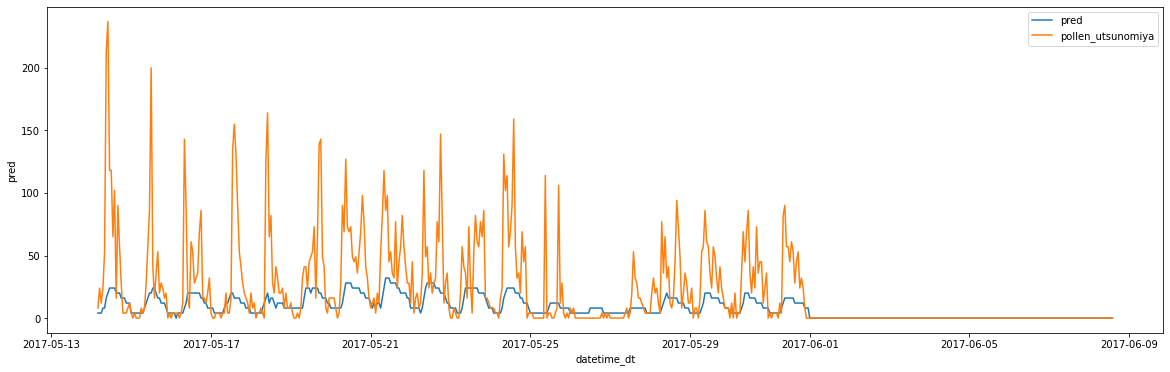

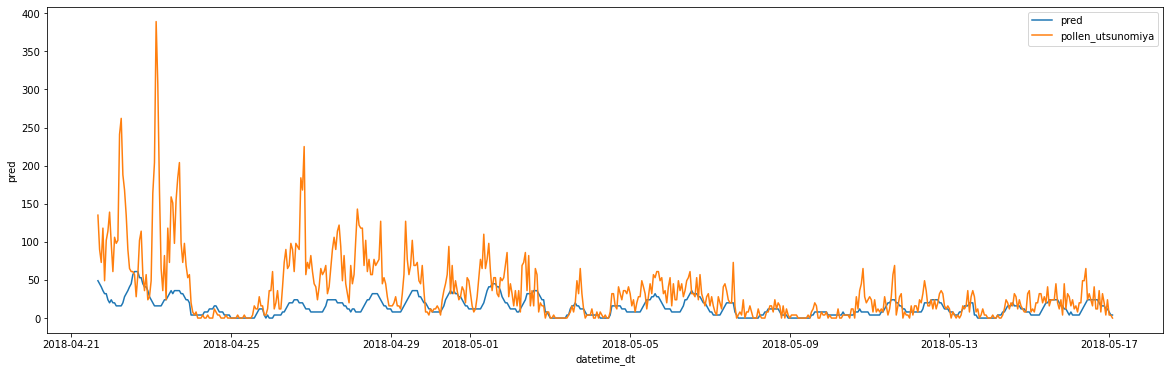

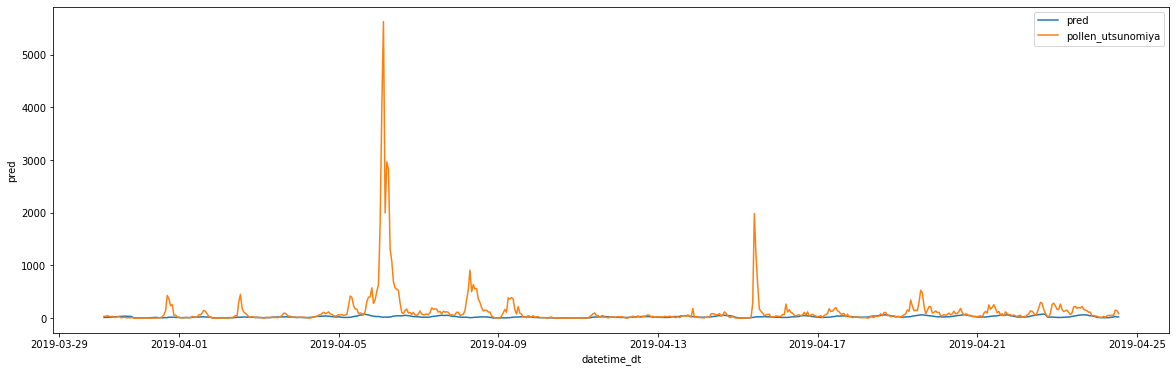

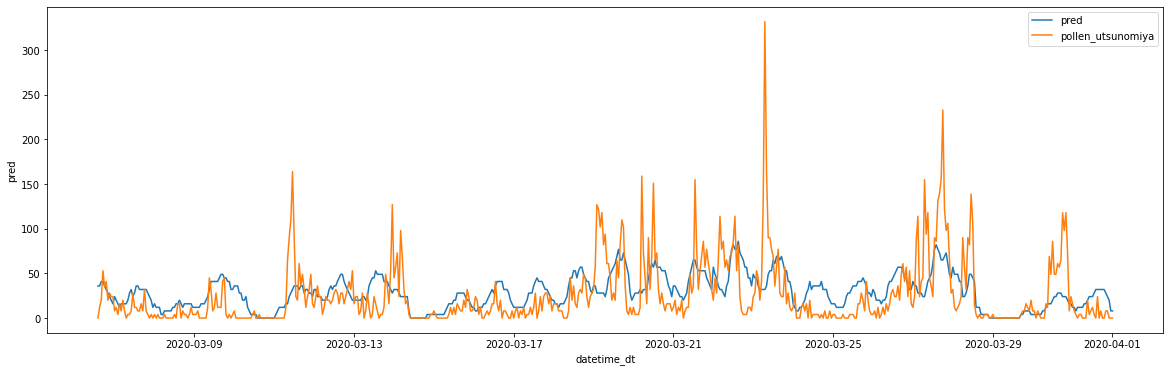

In [28]:
# ut
prediction_ut_1, scores_ut, _val_scores_ut, v_test_scores_ut = run_train(
    _df_ut,
    _df_test_ut,
    q_ut,
    "pollen_utsunomiya",
)

[ 3055  3056  3057 ... 12217 12218 12219]
[    0     1     2 ... 12217 12218 12219]
[    0     1     2 ... 12217 12218 12219]
[   0    1    2 ... 9162 9163 9164]
pollen_tokyo cv_log_by_year


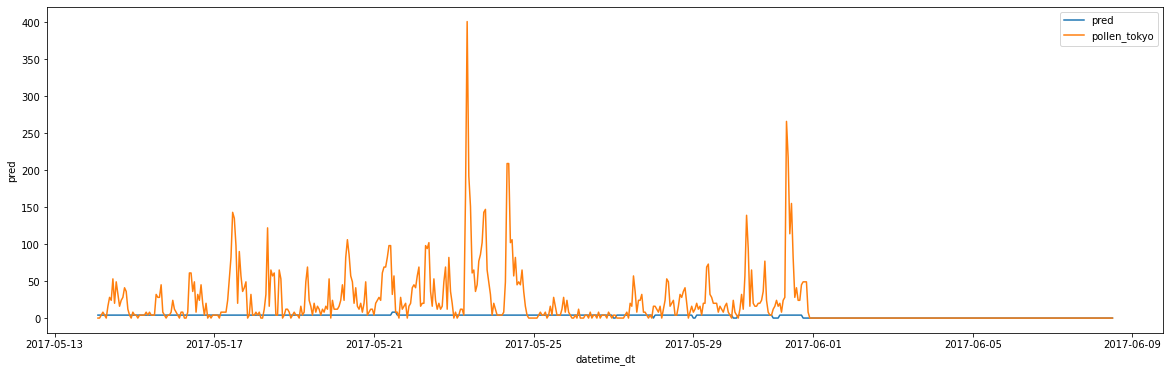

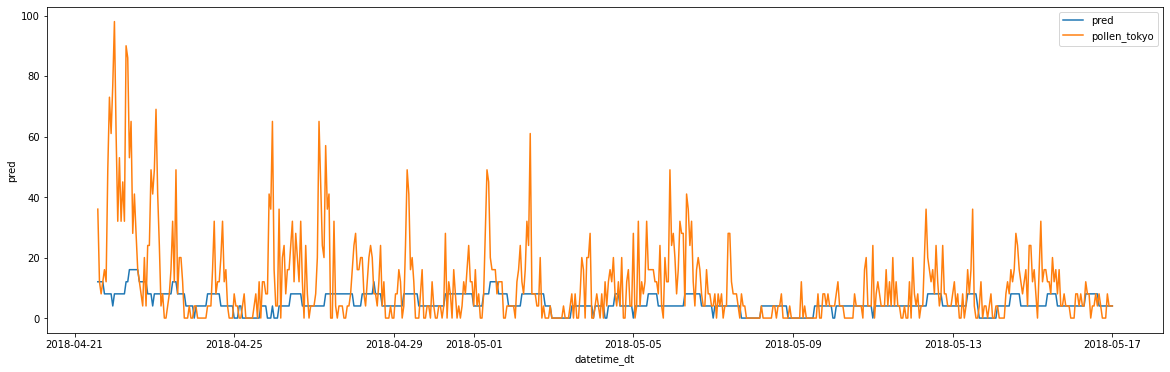

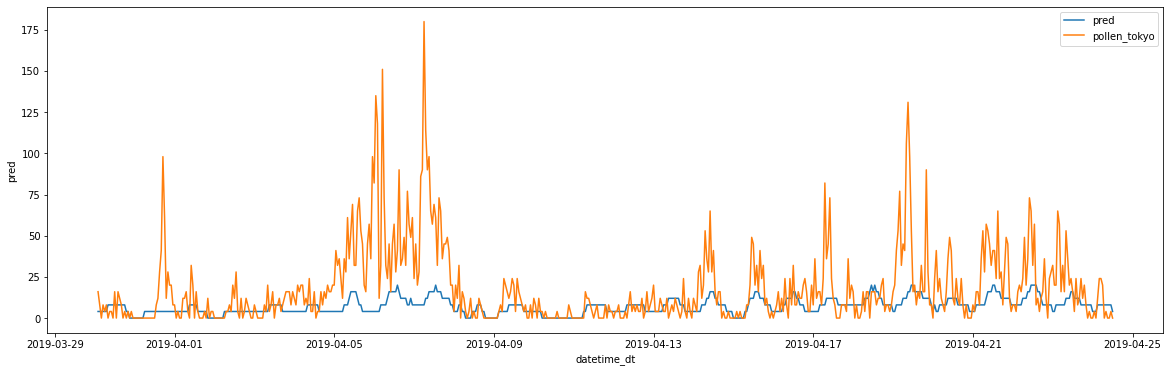

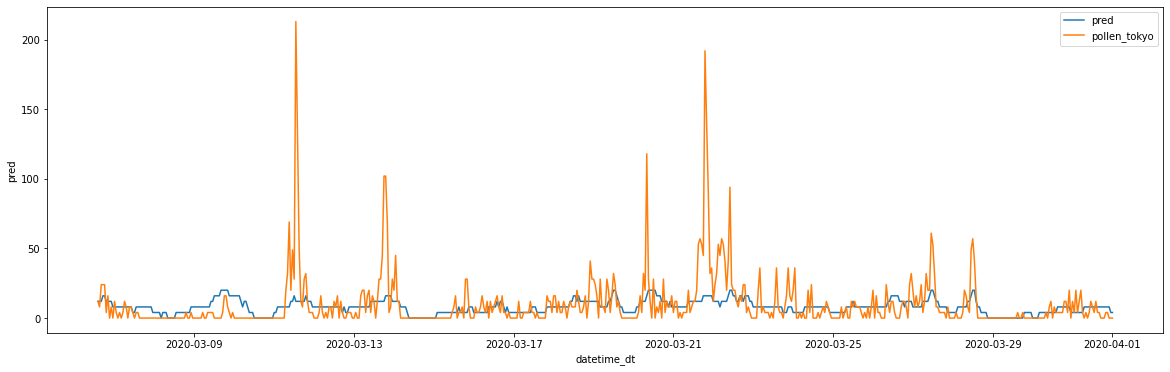

In [29]:
# tk
prediction_tk_1, scores_tk, _val_scores_tk, v_test_scores_tk = run_train(
        _df_tk, _df_test_tk, q_tk, "pollen_tokyo"
)

[ 3060  3061  3062 ... 12237 12238 12239]
[    0     1     2 ... 12237 12238 12239]
[    0     1     2 ... 12237 12238 12239]
[   0    1    2 ... 9177 9178 9179]
pollen_chiba cv_log_by_year


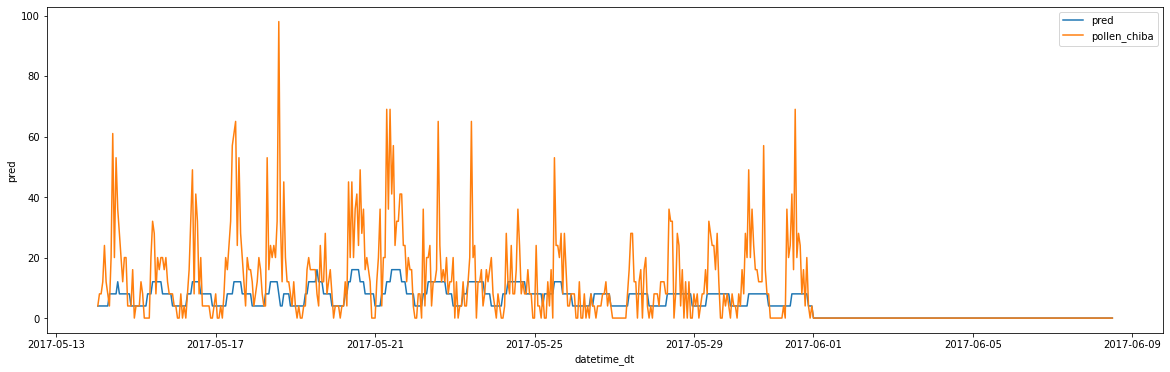

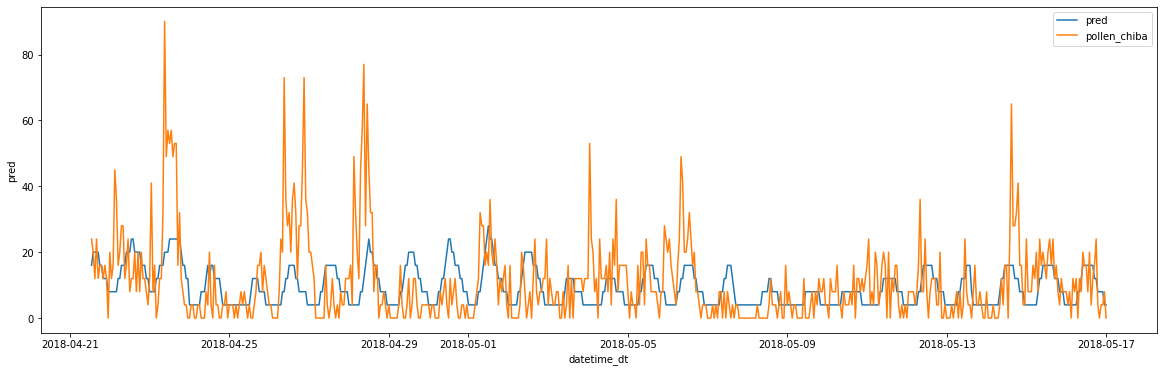

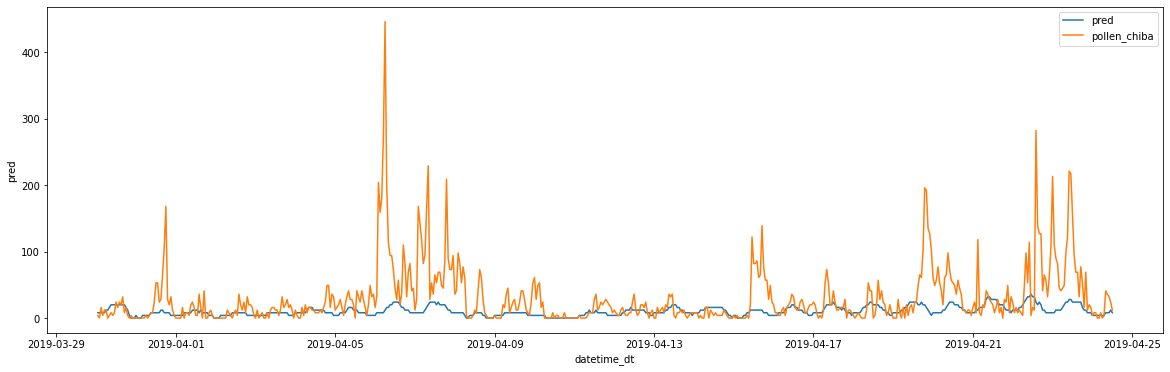

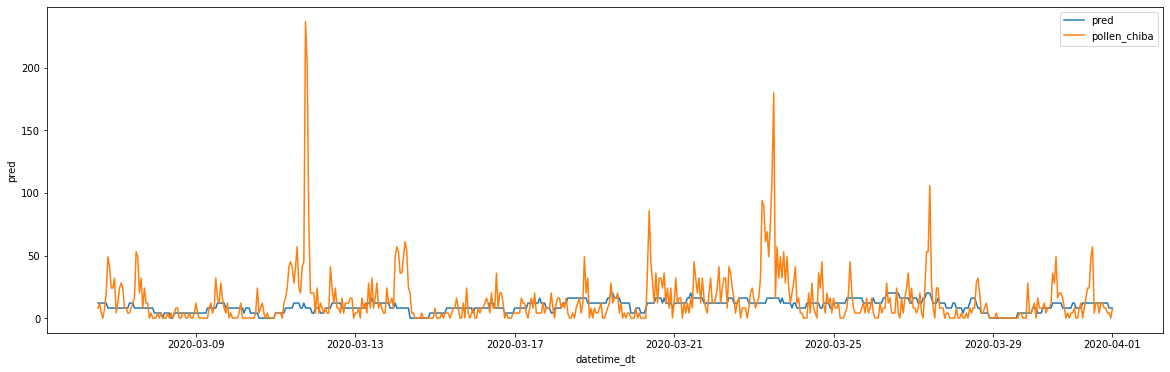

In [30]:
# cb
prediction_cb_1, scores_cb, _val_scores_cb, v_test_scores_cb = run_train(
        _df_cb, _df_test_cb, q_cb, "pollen_chiba"
)

In [31]:
print("=============score")
print(
    f"ut = {np.mean(scores_ut):0.3}",
    f"tk = {np.mean(scores_tk):0.3}",
    f"cb = {np.mean(scores_cb):0.3}",
    f"mean = {np.mean([np.mean(scores_ut), np.mean(scores_tk), np.mean(scores_cb)]):0.3}",
)

print(
    f"ut = {np.mean(v_test_scores_ut):0.3}",
    f"tk = {np.mean(v_test_scores_tk):0.3}",
    f"cb = {np.mean(v_test_scores_cb):0.3}",
    f"mean = {np.mean([np.mean(v_test_scores_ut), np.mean(v_test_scores_tk), np.mean(v_test_scores_cb)]):0.3}",
)

print("=============score")

=============score
ut = 77.6 tk = 23.6 cb = 25.8 mean = 42.3
ut = 41.2 tk = 12.0 cb = 12.0 mean = 21.7
=============score


### Train 2 with pollen other prefecture

In [32]:
_df_ut_2 = _df_ut.copy()
_df_cb_2 = _df_cb.copy()
_df_tk_2 = _df_tk.copy()

_df_test_ut_2 = _df_test_ut.copy()
_df_test_cb_2 = _df_test_cb.copy()
_df_test_tk_2 = _df_test_tk.copy()

[ 3055  3056  3057 ... 12215 12216 12217]
[    0     1     2 ... 12215 12216 12217]
[    0     1     2 ... 12215 12216 12217]
[   0    1    2 ... 9161 9162 9163]
pollen_utsunomiya cv_log_by_year


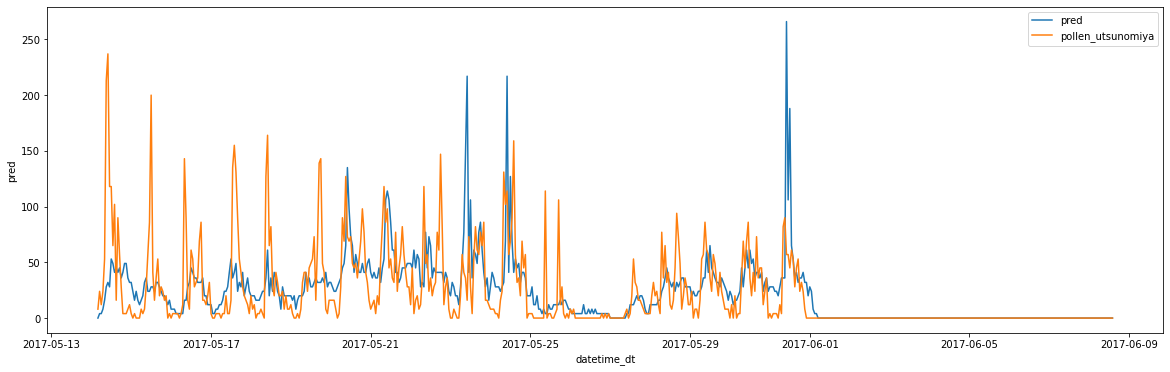

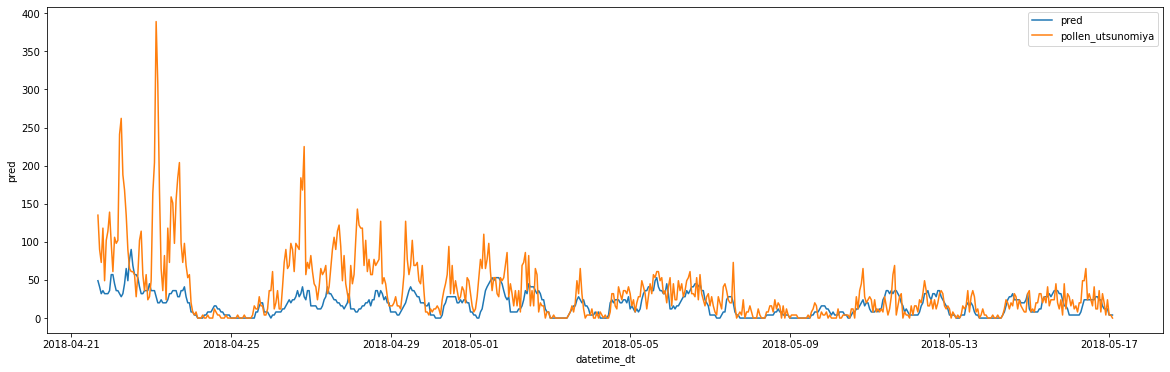

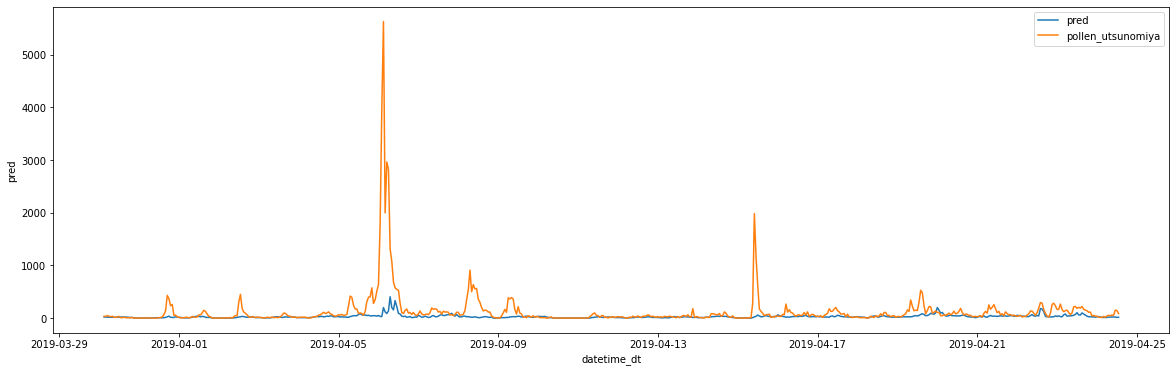

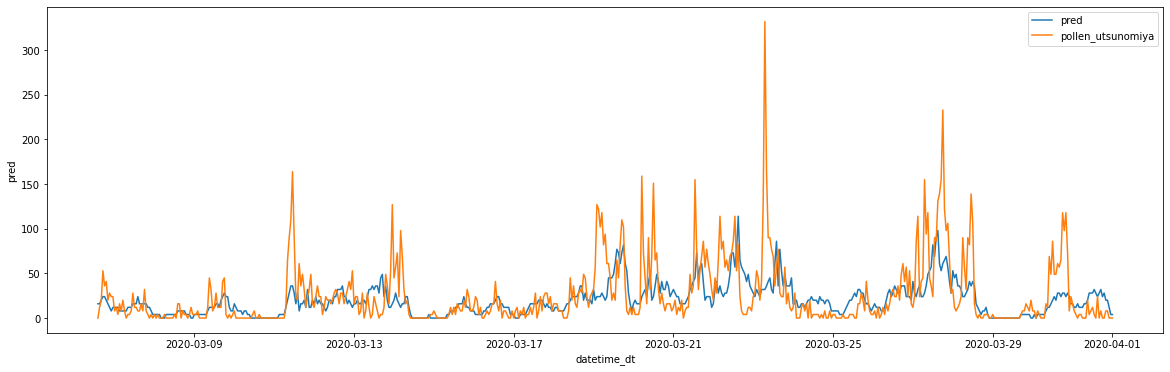

In [33]:
_df_test_ut_2["pollen_tokyo"] = prediction_tk_1
_df_test_ut_2["pollen_chiba"] = prediction_cb_1
_df_test_ut_2["pollen_utsunomiya_pseudo"] = prediction_ut_1

_df_ut_2["pollen_utsunomiya_pseudo"] = _df_ut["pollen_utsunomiya"]

_df_ut_2, _df_test_ut_2 = make_feature(
    _df_ut_2, _df_test_ut_2, make_feature_ut_2, cols=["pollen_utsunomiya"]
)
prediction_ut, scores_ut, _val_scores_ut, v_test_scores_ut = run_train(
     _df_ut_2, _df_test_ut_2, q_ut, "pollen_utsunomiya", label_cols=["pollen_utsunomiya"]
)

#prediction_ut = prediction_ut_1

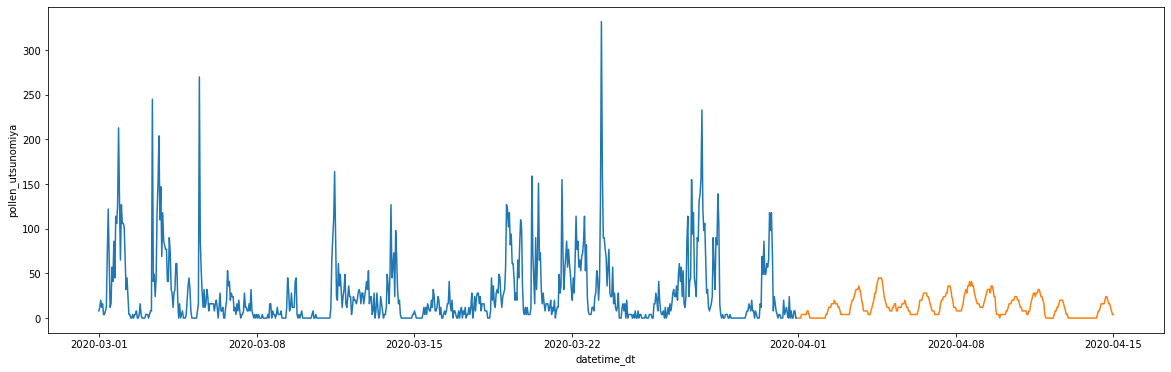

In [34]:
__df_test = _df_test_ut_2.copy()
__df_test["pollen_utsunomiya"] = prediction_ut
plt.figure(figsize=(20, 6))
ax = sns.lineplot(data=_df_ut[(_df_ut.year == 2020) & (_df_ut.month == 3)], x="datetime_dt", y="pollen_utsunomiya")
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_utsunomiya")

In [35]:
prediction_ut

array([ 0.,  0.,  0.,  4.,  4.,  4.,  4.,  4.,  4.,  8.,  8.,  4.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  4.,  4.,  8., 12., 12., 12., 16., 16., 16., 20.,
       16., 16., 16., 12., 12.,  8.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4., 12., 16., 20., 20., 24., 28., 32., 32., 32., 36.,
       32., 28., 20., 16.,  8.,  8.,  8.,  8.,  8.,  4.,  4.,  4.,  8.,
       12., 16., 20., 28., 28., 36., 41., 45., 45., 45., 45., 41., 32.,
       24., 20., 16., 12., 12., 12.,  8.,  8.,  8., 12., 12., 16., 16.,
        8.,  8., 12., 12., 12., 12., 16., 16., 16., 20., 16., 12., 12.,
        8.,  8.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  8., 12., 20.,
       20., 20., 24., 28., 28., 28., 28., 24., 24., 20., 16., 12.,  8.,
        8.,  8.,  4.,  4.,  4.,  4.,  4.,  8., 16., 20., 20., 24., 24.,
       24., 28., 28., 36., 36., 36., 32., 24., 20., 12., 12., 12.,  8.,
        8.,  8.,  8.,  8.,  8., 12., 16., 24., 28., 32., 28., 36

[ 3055  3056  3057 ... 12217 12218 12219]
[    0     1     2 ... 12217 12218 12219]
[    0     1     2 ... 12217 12218 12219]
[   0    1    2 ... 9162 9163 9164]
pollen_tokyo cv_log_by_year


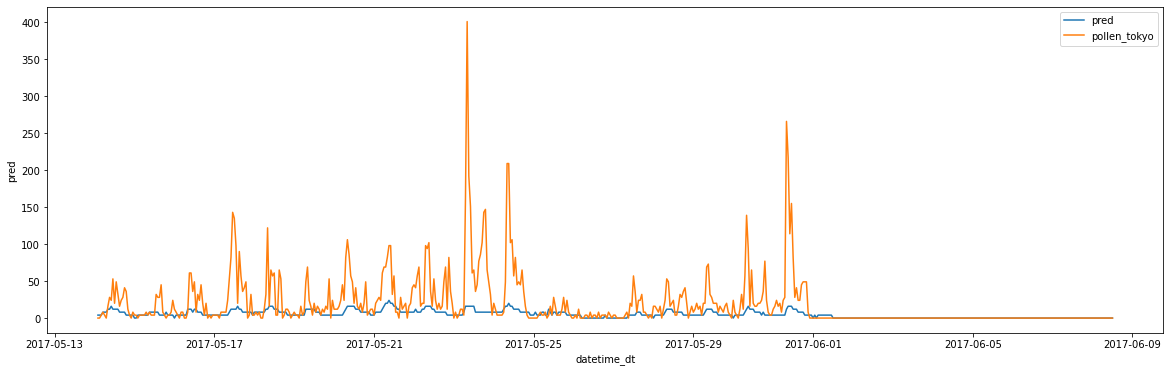

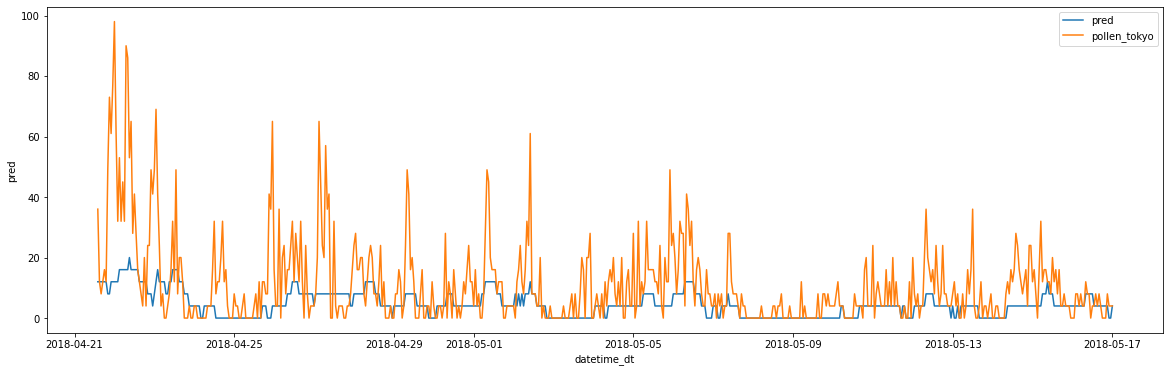

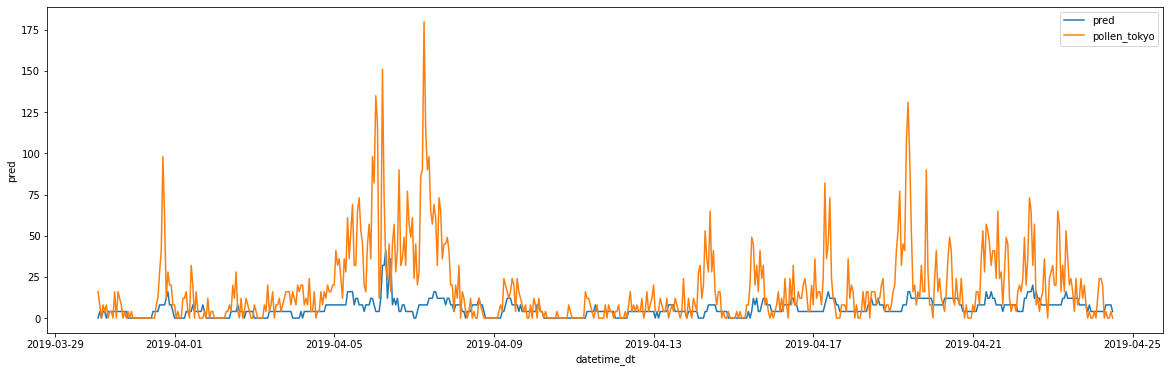

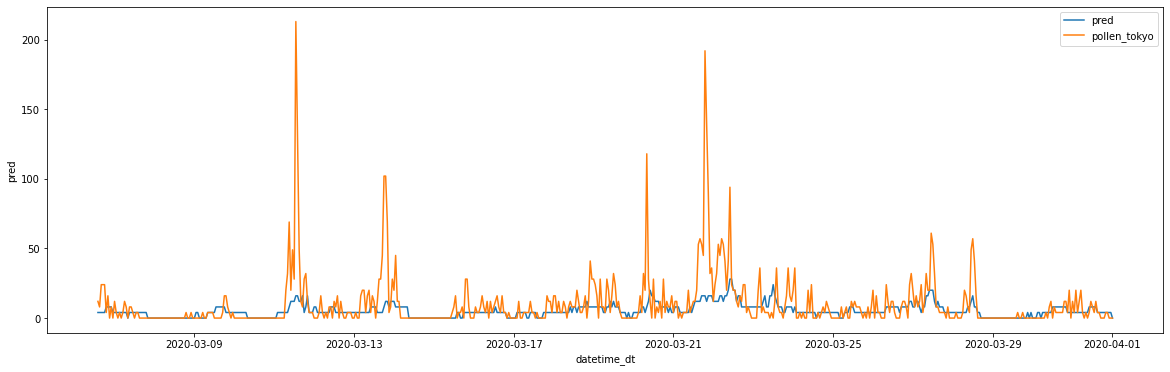

In [36]:
_df_test_tk_2["pollen_utsunomiya"] = prediction_ut_1
_df_test_tk_2["pollen_chiba"] = prediction_cb_1
_df_test_tk_2["pollen_tokyo_pseudo"] = prediction_tk_1

_df_tk_2["pollen_tokyo_pseudo"] = _df_tk["pollen_tokyo"]

_df_tk_2, _df_test_tk_2 = make_feature(
    _df_tk_2, _df_test_tk_2, make_feature_tk_2, cols=["pollen_tokyo"]
)

prediction_tk, scores_tk, _val_scores_tk, v_test_scores_tk = run_train(
    _df_tk_2, _df_test_tk_2, q_tk, "pollen_tokyo", label_cols=["pollen_tokyo"]
)

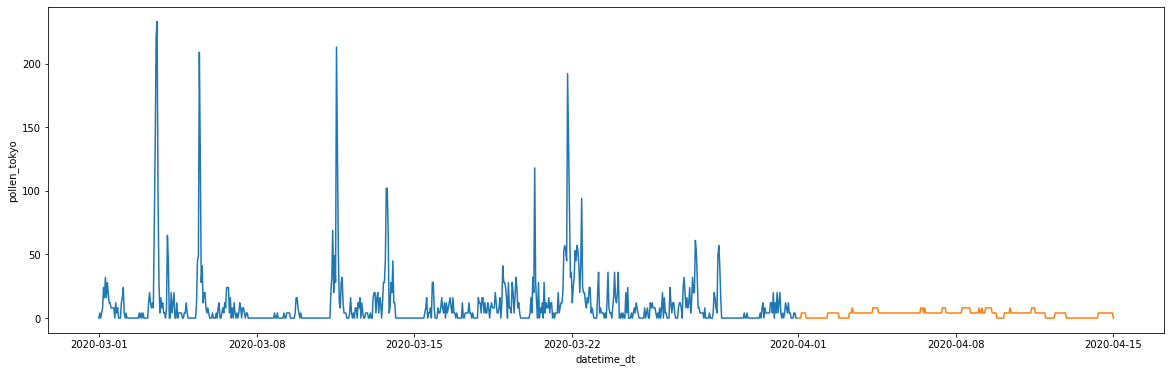

In [37]:
__df_test = _df_test_tk.copy()
__df_test["pollen_tokyo"] = prediction_tk
plt.figure(figsize=(20, 6))
ax = sns.lineplot(data=_df_tk[(_df_tk.year == 2020) & (_df_tk.month == 3)], x="datetime_dt", y="pollen_tokyo")
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_tokyo")

[ 3055  3056  3057 ... 12217 12218 12219]
[    0     1     2 ... 12217 12218 12219]
[    0     1     2 ... 12217 12218 12219]
[   0    1    2 ... 9162 9163 9164]
pollen_chiba cv_log_by_year


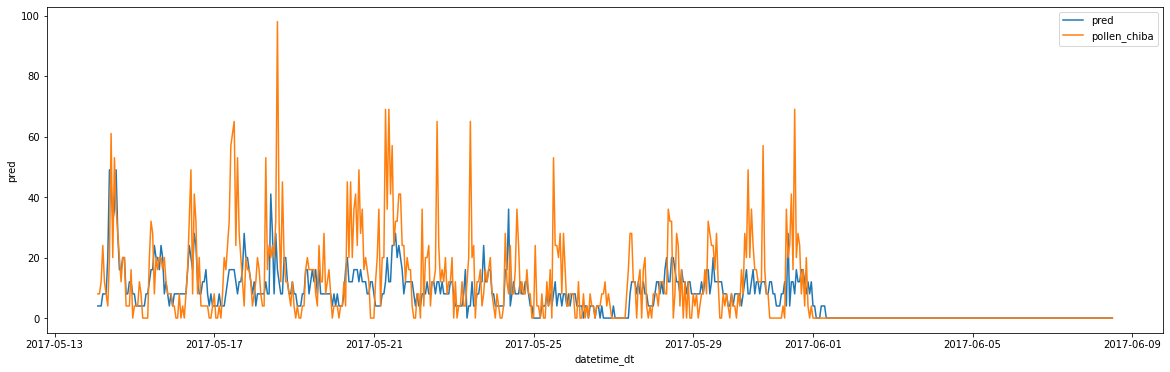

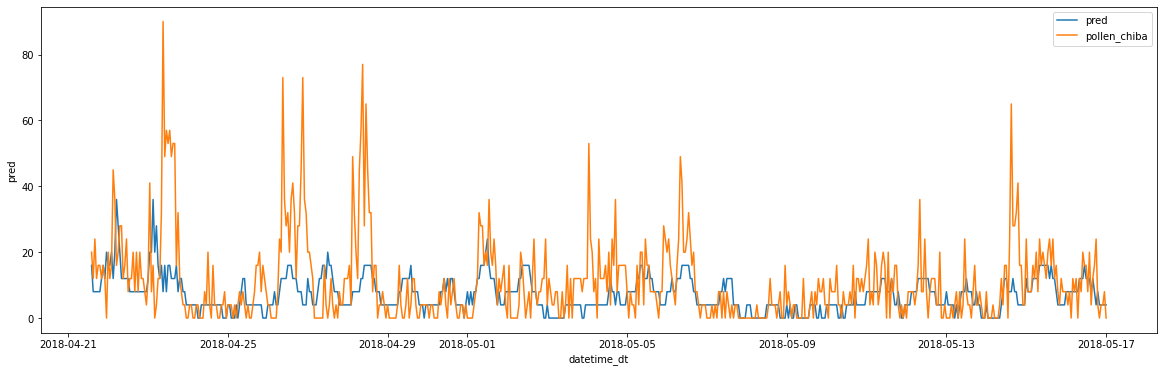

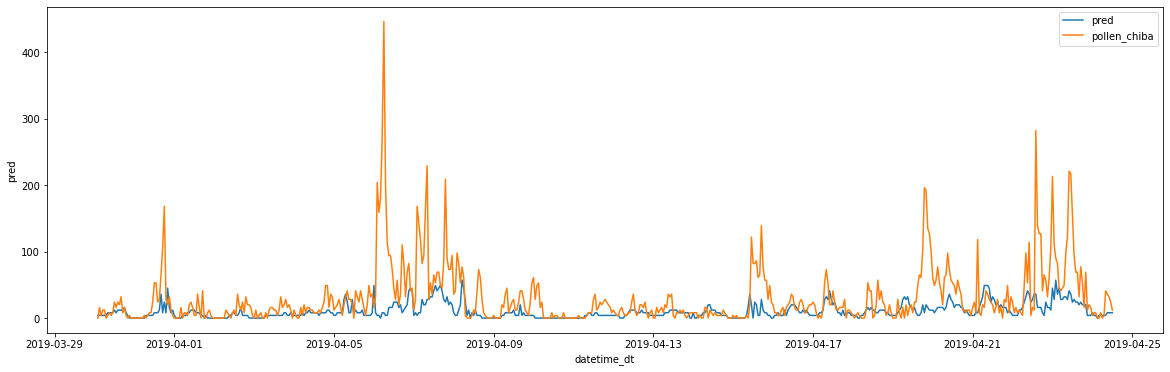

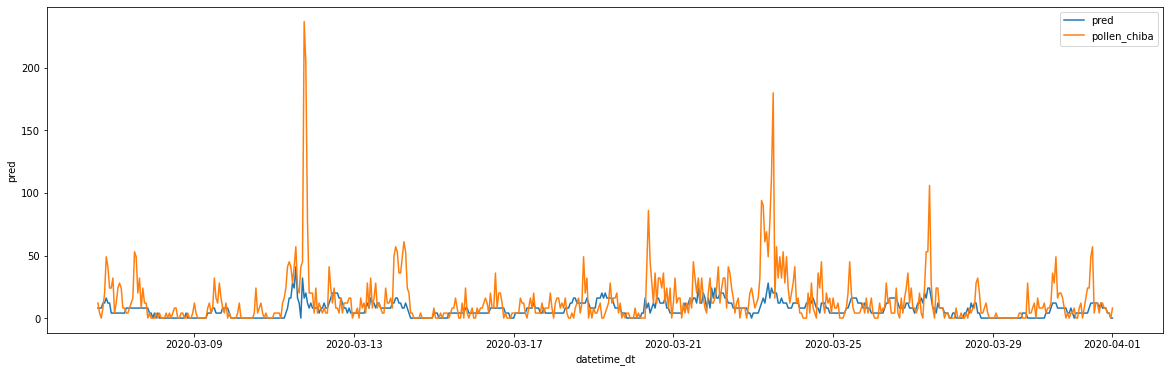

In [38]:
_df_test_cb_2["pollen_utsunomiya"] = prediction_ut_1
_df_test_cb_2["pollen_tokyo"] = prediction_tk_1

_df_test_cb_2["pollen_chiba_pseudo"] = prediction_cb_1
_df_cb_2["pollen_chiba_pseudo"] = _df_cb["pollen_chiba"]

_df_cb_2, _df_test_cb_2 = make_feature(
    _df_cb_2, _df_test_cb_2, make_feature_cb_2, cols=["pollen_chiba"]
)

prediction_cb, scores_cb, _val_scores_cb, v_test_scores_cb = run_train(
    _df_cb_2, _df_test_cb_2, q_cb, "pollen_chiba", label_cols=["pollen_chiba"]
)

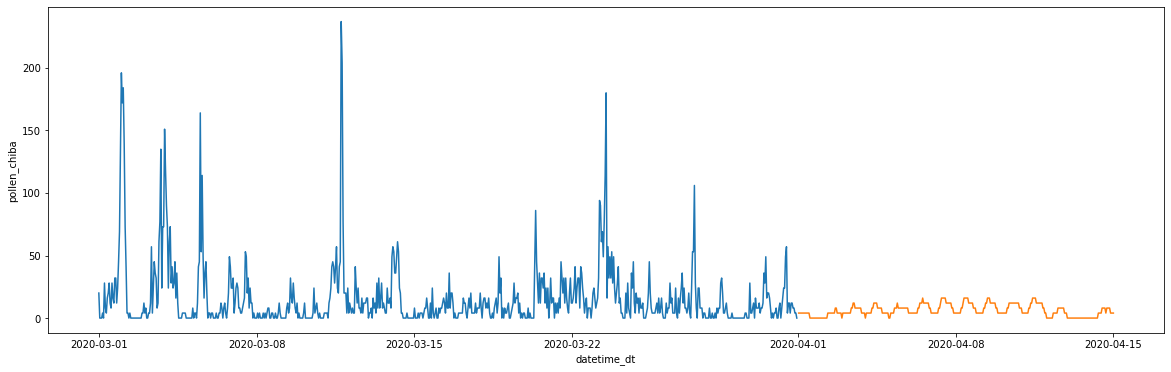

In [39]:
__df_test = _df_test_cb.copy()
__df_test["pollen_chiba"] = prediction_cb
plt.figure(figsize=(20, 6))
ax = sns.lineplot(data=_df_cb[(_df_cb.year == 2020) & (_df_ut.month == 3)], x="datetime_dt", y="pollen_chiba")
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_chiba")

In [40]:

print("=============score")
print(f"seed {Config.seed}")
print(
    "val  score",
    f"ut = {np.mean(scores_ut):0.4}",
    f"tk = {np.mean(scores_tk):0.4}",
    f"cb = {np.mean(scores_cb):0.4}",
    f"mean = {np.mean([np.mean(scores_ut), np.mean(scores_tk), np.mean(scores_cb)]):0.4}",
)

print(
    "test score",
    f"ut = {np.mean(v_test_scores_ut):0.4}",
    f"tk = {np.mean(v_test_scores_tk):0.4}",
    f"cb = {np.mean(v_test_scores_cb):0.4}",
    f"mean = {np.mean([np.mean(v_test_scores_ut), np.mean(v_test_scores_tk), np.mean(v_test_scores_cb)]):0.4}",
)


=============score
seed 42
val  score ut = 83.03 tk = 25.44 cb = 27.21 mean = 45.23
test score ut = 38.89 tk = 11.31 cb = 11.45 mean = 20.55


In [41]:
df_sub = _df_test_ut[["datetime"]]
df_sub.loc[:, "pollen_utsunomiya"] = prediction_ut
df_sub.loc[:, "pollen_chiba"] = prediction_cb
df_sub.loc[:, "pollen_tokyo"] = prediction_tk
df_sub.to_csv(f"sub_mlp_{Config.seed}_{Config.n_splits}.csv", index=None)

#### 3回学習 -> LB: 12.54229
- val  score ut = 75.45 tk = 22.38 cb = 24.64 mean = 40.82
- test score ut = 40.52 tk = 10.95 cb = 11.36 mean = 20.94

#### seed 42 cv=4 下がった target のlag max/min 追加 LB: 12.74129
- val  score ut = 75.1 tk = 22.14 cb = 24.33 mean = 40.52
- test score ut = 40.01 tk = 10.92 cb = 11.22 mean = 20.72

#### seed 40 cv=4 shuffle =True LB: 12.34328
- val  score ut = 74.35 tk = 21.8 cb = 23.96 mean = 40.03
- test score ut = 12.25 tk = 6.424 cb = 8.489 mean = 9.054

#### seed 42 cv=4 shuffle =True LB: 12.36318
- val  score ut = 74.39 tk = 21.8 cb = 23.85 mean = 40.02
- test score ut = 12.24 tk = 6.432 cb = 8.471 mean = 9.048
#### seed 42 cv=5 12.30348
- val  score ut = 75.31 tk = 22.4 cb = 24.5 mean = 40.74
- test score ut = 83.61 tk = 30.11 cb = 21.43 mean = 45.05

#### seed 42 cv=4 12.22388
- seed 42
- val  score ut = 75.43 tk = 22.38 cb = 24.64 mean = 40.82
- test score ut = 40.46 tk = 10.95 cb = 11.36 mean = 20.92

#### seed 42 CV=3
- LB 12.32338
- val  score ut = 75.27 tk = 22.36 cb = 24.79 mean = 40.81
- test score ut = 75.34 tk = 14.71 cb = 31.33 mean = 40.46

# q はtrain/val のみ
## 2回目はqを変えてみる
### 直近を入れるのやめる LB: 12.32338
- val  score ut = 75.27 tk = 22.36 cb = 24.79 mean = 40.81
- test score ut = 75.34 tk = 14.71 cb = 31.33 mean = 40.46

### 最も近い値の補正
- val  score ut = 63.52 tk = 15.82 cb = 16.39 mean = 31.91
- test score ut = 65.78 tk = 9.658 cb = 24.22 mean = 33.22

### 直近も入れる LB
seed 42
- val  score ut = 63.68 tk = 15.98 cb = 16.48 mean = 32.05
- test score ut = 65.95 tk = 9.804 cb = 24.28 mean = 33.35

### k-foldに変更 LB12.63460
- val  score ut = 75.3 tk = 22.44 cb = 24.86 mean = 40.87
- test score ut = 75.43 tk = 14.84 cb = 31.35 mean = 40.54

### time series cvに変更 & 直近の花粉も入れる LB: 14.49450
- val  score ut = 87.34 tk = 21.0 cb = 25.56 mean = 44.63
- test score ut = 49.49 tk = 9.351 cb = 13.23 mean = 24.02
### q_tk 30 LB: 12.92040 seed 42
- val  score ut = 18.55 tk = 9.9 cb = 12.8 mean = 13.75
- test score ut = 20.85 tk = 7.63 cb = 9.353 mean = 12.61

### hour sin/cos mult sun rate をくわえる
- val  score ut = 18.55 tk = 10.36 cb = 12.8 mean = 13.9
- test score ut = 20.85 tk = 7.846 cb = 9.353 mean = 12.68

### over fit してそうなので、rolling3 pollen tokyoは消す
- val  score ut = 18.62 tk = 10.33 cb = 12.82 mean = 13.92
- test score ut = 20.97 tk = 7.846 cb = 9.373 mean = 12.73

### utに特徴量追加
1
- ut = 20.9 tk = 11.5 cb = 13.2 mean = 15.2
- ut = 23.6 tk = 8.88 cb = 9.93 mean = 14.1

2
- val  score ut = 15.39 tk = 8.556 cb = 10.32 mean = 11.42
- test score ut = 17.19 tk = 6.316 cb = 7.206 mean = 10.24


### tokyoに特徴量追加
1
- ut = 20.9 tk = 11.5 cb = 13.2 mean = 15.2
- ut = 23.6 tk = 8.88 cb = 9.93 mean = 14.1

2
- val  score ut = 15.27 tk = 8.556 cb = 10.32 mean = 11.38
- test score ut = 17.0 tk = 6.316 cb = 7.206 mean = 10.17

### presudo 追加
- val  score ut = 15.27 tk = 8.651 cb = 10.32 mean = 11.42
- test score ut = 17.0 tk = 6.542 cb = 7.206 mean = 10.25

### ut にpresudo label LB: 12.98010
- val  score ut = 7.725 tk = 10.38 cb = 13.03 mean = 10.38
- test score ut = 8.176 tk = 7.924 cb = 9.402 mean = 8.501

### q_tk 20 -> 25 LB: 13.05970
- val  score ut = 19.35 tk = 10.38 cb = 13.03 mean = 14.25
- test score ut = 23.56 tk = 7.924 cb = 9.402 mean = 13.63

### やっぱlogつける & ut 2回目もやる
- val  score ut = 19.35 tk = 10.46 cb = 13.03 mean = 14.28
- test score ut = 23.56 tk = 8.051 cb = 9.402 mean = 13.67


#### q_ut 25 -> 50 & logはすず
- val  score ut = 21.35 tk = 10.46 cb = 13.03 mean = 14.95
- test score ut = 23.93 tk = 8.051 cb = 9.402 mean = 13.79


#### q_ut 20 -> 25
- val  score ut = 21.75 tk = 10.46 cb = 13.03 mean = 15.08
- test score ut = 24.68 tk = 8.051 cb = 9.402 mean = 14.04

### q_cb 20 -> 36 LB: 12.98010
- val  score ut = 22.11 tk = 10.46 cb = 13.03 mean = 15.2 
- test score ut = 25.26 tk = 8.051 cb = 9.402 mean = 14.24

###
- val  score ut = 22.11 tk = 10.46 cb = 13.59 mean = 15.39 
- test score ut = 25.26 tk = 8.051 cb = 10.13 mean = 14.48
###
- val  score ut = 22.11 tk = 10.46 cb = 13.59 mean = 15.39
- test score ut = 25.26 tk = 8.051 cb = 10.13 mean = 14.48



# score
- val  score ut = 4.47 tk = 3.799 cb = 4.447 mean = 4.239  CVの仕方変えるシングルモデル　LB: 12.90
- test score ut = 4.627 tk = 3.944 cb = 4.592 mean = 4.387

- val  score ut = 2.883 tk = 3.019 cb = 3.388 mean = 3.097
- test score ut = 2.877 tk = 3.932 cb = 3.992 mean = 3.6

- val  score ut = 2.883 tk = 3.033 cb = 3.388 mean = 3.101
- test score ut = 2.877 tk = 4.038 cb = 3.992 mean = 3.636

##### aaa
- ut = 2.8789855072463766 tk = 3.0431222707423577 cb = 3.387709497206704 mean = 3.1032724250651462 特徴量外すnull を消す CV下がる 
- ut = 2.8807803468208095 tk = 3.0642701525054465 cb = 3.407138873396542 mean = 3.117396457574266 特徴量いれてCVあがったのでLB確認 LB: 12.75124
- ut = 2.8807803468208095 tk = 3.0435729847494555 cb = 3.407138873396542 mean = 3.110497401655602 4の倍数に調整 CV下がったのでLB確認 LB: 12.70149
- ut = 2.9985830498474346 tk = 3.169181452694578 cb = 3.538071370345608 mean = 3.2352786242958733 他特徴いれてCV下がったのでLB確認 LB 12.86014 LB下がる
- ut = 2.9979593490287315 tk = 3.1758821599239524 cb = 3.539707442852777 mean = 3.23784965060182 全データ学習にして time series split  LB 12.75404
- ut = 2.1408123593269544 tk = 2.728863062494766 cb = 2.921619055380538 mean = 2.597098159067419 千葉だけ日照時間 LB: 12.87519
- ut = 2.185769442059023 tk = 2.7444023657299055 cb = 2.921619055380538 mean = 2.617263621056489 日照時間を追加 LB: 12.78571
- ut = 2.1408123593269544 tk = 2.728863062494766 cb = 2.9456533248344265 mean = 2.605109582218715